In [18]:
!pip install snntorch --quiet

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cpu
PyTorch version: 2.9.0+cu126


Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


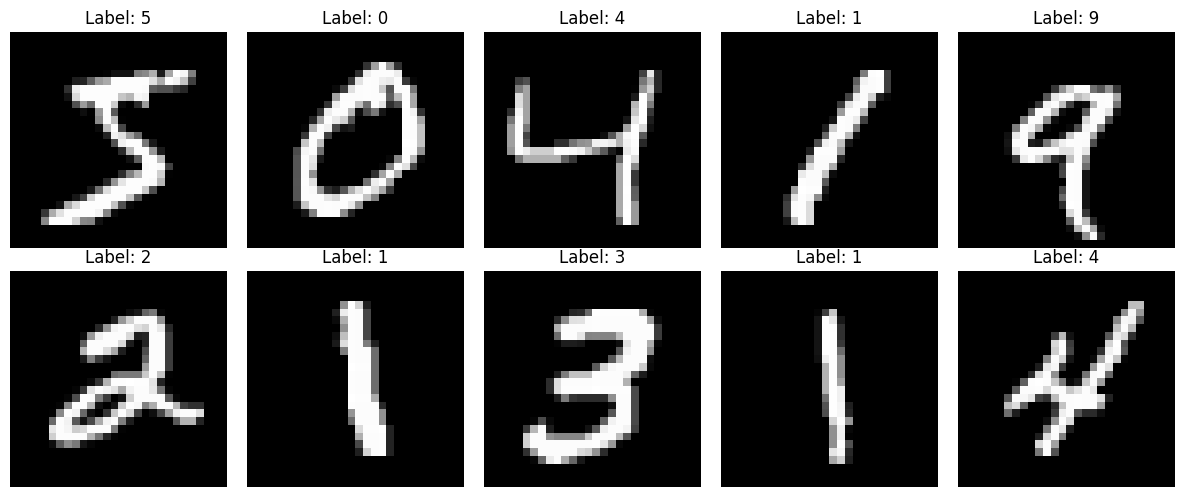

In [15]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.flat):
    img, label = train_dataset[idx]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples.png', dpi=150, bbox_inches='tight')
plt.show()



In [16]:
# Hyperparameters
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=num_workers, drop_last=True)

data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch shape: torch.Size([128, 1, 28, 28])
Labels shape: torch.Size([128])
Number of training batches: 468
Number of test batches: 78


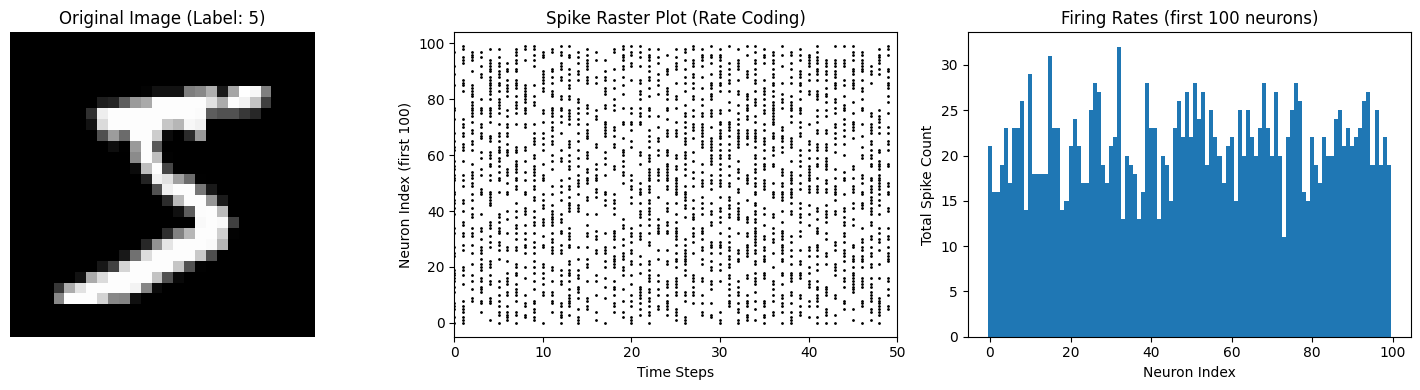

Input: Static image torch.Size([1, 28, 28])
Output: Spike trains torch.Size([50, 784]) (time_steps × neurons)
Total spikes generated: 19626


In [17]:
num_steps = 50

def rate_coding_visualization(image, label, num_steps=50):
    """
    Visualize how a single image is converted to spike trains using rate coding
    """

    img_flat = image.squeeze().flatten()  # 784 pixels

    spike_trains = torch.rand(num_steps, 784) < img_flat.abs()

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))


    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title(f'Original Image (Label: {label})')
    axes[0].axis('off')

    spike_times, neuron_ids = spike_trains[:, :100].nonzero(as_tuple=True)
    axes[1].scatter(spike_times.numpy(), neuron_ids.numpy(), s=1, c='black')
    axes[1].set_xlabel('Time Steps')
    axes[1].set_ylabel('Neuron Index (first 100)')
    axes[1].set_title('Spike Raster Plot (Rate Coding)')
    axes[1].set_xlim(0, num_steps)

    spike_counts = spike_trains[:, :100].sum(dim=0)
    axes[2].bar(range(100), spike_counts.numpy(), width=1)
    axes[2].set_xlabel('Neuron Index')
    axes[2].set_ylabel('Total Spike Count')
    axes[2].set_title('Firing Rates (first 100 neurons)')

    plt.tight_layout()
    plt.savefig('spike_encoding_demo.png', dpi=150, bbox_inches='tight')
    plt.show()

    return spike_trains

sample_img, sample_label = train_dataset[0]
spike_trains = rate_coding_visualization(sample_img, sample_label, num_steps)

print(f"Input: Static image {sample_img.shape}")
print(f"Output: Spike trains {spike_trains.shape} (time_steps × neurons)")
print(f"Total spikes generated: {spike_trains.sum().item()}")


Membrane time constant (τm): 20.0 ms
Time step (dt): 1.0 ms
Decay factor (β): 0.9512
Refractory period: 5 ms (as per proposal)
Threshold: Adaptive (will be learned)


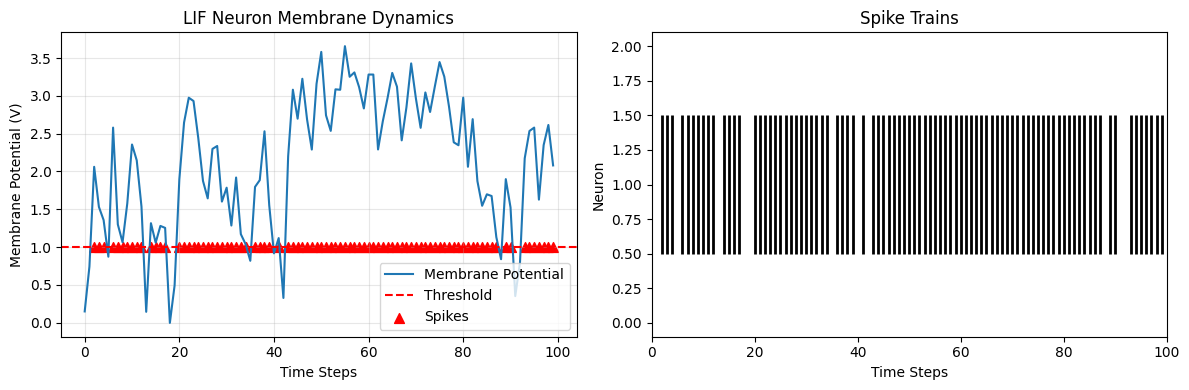

Total spikes in test: 903.0


In [5]:
# LIF neuron parameters
tau_mem = 20e-3
dt = 1e-3
beta = np.exp(-dt/tau_mem)

print(f"Membrane time constant (τm): {tau_mem*1000} ms")
print(f"Time step (dt): {dt*1000} ms")
print(f"Decay factor (β): {beta:.4f}")
print(f"Refractory period: 5 ms (as per proposal)")
print(f"Threshold: Adaptive (will be learned)")


spike_grad = surrogate.fast_sigmoid()  # Surrogate gradient


lif_neuron = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

test_current = torch.randn(100, 1, 10) * 0.5 + 1.0

# Run
mem_rec = []
spk_rec = []

for step in range(100):

    spk, mem = lif_neuron(test_current[step])
    mem_rec.append(mem.detach())
    spk_rec.append(spk.detach())

mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mem_rec[:, 0, 0].numpy(), label='Membrane Potential')
plt.axhline(y=1.0, color='r', linestyle='--', label='Threshold')
spike_times = spk_rec[:, 0, 0].nonzero().squeeze().numpy()
if spike_times.size > 0:
    plt.scatter(spike_times, np.ones_like(spike_times), c='red', s=50, marker='^', label='Spikes')
plt.xlabel('Time Steps')
plt.ylabel('Membrane Potential (V)')
plt.title('LIF Neuron Membrane Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
if spike_times.size > 0:
    plt.eventplot(spike_times, colors='black', linewidths=2)
plt.xlabel('Time Steps')
plt.ylabel('Neuron')
plt.title('Spike Trains')
plt.xlim(0, 100)

plt.tight_layout()
plt.savefig('lif_neuron_test.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Total spikes in test: {spk_rec.sum().item()}")


In [6]:


input_size = 28 * 28  # 784 input neurons (flattened MNIST)
hidden_size = 400     # 400 excitatory LIF neurons
output_size = 10      # 10 output neurons (digits 0-9)
num_steps = 50        # Simulation time steps

class SpikingNeuralNetwork(nn.Module):
    """
    SNN with LIF neurons for MNIST classification
    Architecture: 784 (input) -> 400 (hidden LIF) -> 10 (output LIF)
    """
    def __init__(self, beta=0.95):
        super().__init__()


        spike_grad = surrogate.fast_sigmoid()

        self.fc1 = nn.Linear(input_size, hidden_size, bias=False)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

        self.fc2 = nn.Linear(hidden_size, output_size, bias=False)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        """
        Forward pass for one time step
        x: input spike train [batch_size, 784]
        Returns: (spk2, mem1, mem2) - output spikes and membrane states
        """
        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1, self.mem1)


        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2, self.mem2)

        self.mem1 = mem1
        self.mem2 = mem2

        return spk2, mem1, mem2

    def init_membrane(self, batch_size, device):
        """Initialize membrane potentials to zero"""
        self.mem1 = self.lif1.init_leaky().to(device)
        self.mem2 = self.lif2.init_leaky().to(device)

# Initialize network
net = SpikingNeuralNetwork(beta=beta).to(device)

print(net)
print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
print(f"Input layer: 784 neurons (28×28 pixels)")
print(f"Hidden layer: 400 LIF neurons")
print(f"Output layer: 10 LIF neurons")


net.init_membrane(batch_size, device)
test_input = torch.rand(batch_size, input_size).to(device)
test_spk, test_mem1, test_mem2 = net(test_input)


print(f"Test forward pass:")
print(f"  Input shape: {test_input.shape}")
print(f"  Output spikes shape: {test_spk.shape}")
print(f"  Hidden membrane shape: {test_mem1.shape}")
print(f"  Output membrane shape: {test_mem2.shape}")


SpikingNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=400, bias=False)
  (lif1): Leaky()
  (fc2): Linear(in_features=400, out_features=10, bias=False)
  (lif2): Leaky()
)
Total parameters: 317,600
Input layer: 784 neurons (28×28 pixels)
Hidden layer: 400 LIF neurons
Output layer: 10 LIF neurons
Test forward pass:
  Input shape: torch.Size([128, 784])
  Output spikes shape: torch.Size([128, 10])
  Hidden membrane shape: torch.Size([128, 400])
  Output membrane shape: torch.Size([128, 10])


Input batch shape: torch.Size([128, 1, 28, 28])
Original data range: [-0.424, 2.821]

Output spike recording shape: torch.Size([50, 128, 10])
Output membrane recording shape: torch.Size([50, 128, 10])
Total output spikes: 1157


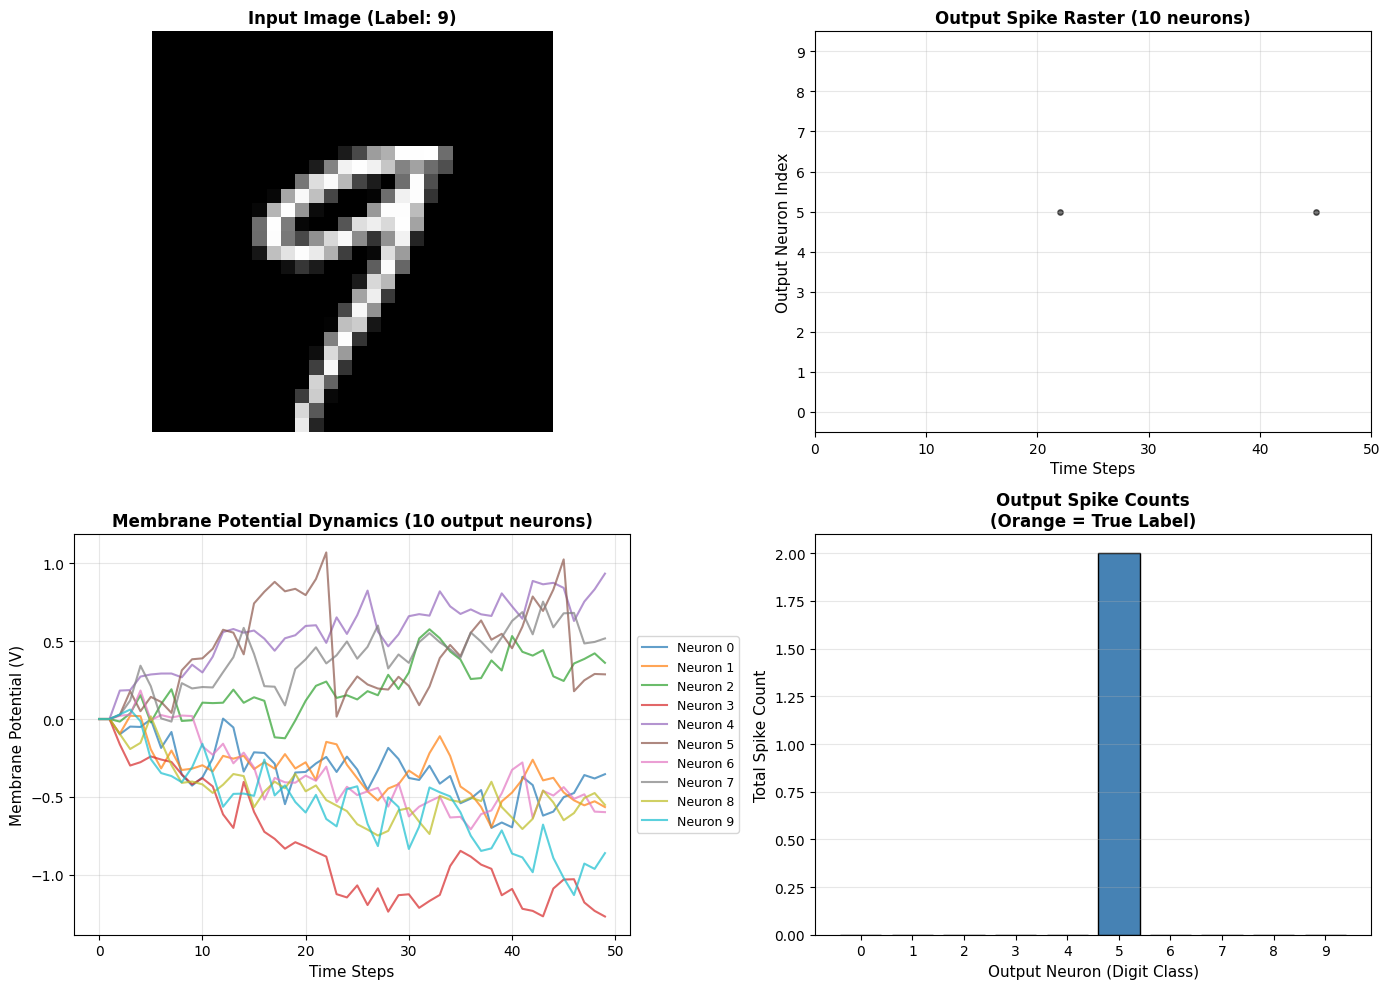

Average spikes per output neuron: 0.20
Max spikes: 2, Min spikes: 0


In [7]:

def forward_pass_through_time(net, data, num_steps=50):
    """
    Process a batch of images through the SNN over multiple time steps

    Args:
        net: Spiking neural network
        data: Input images [batch_size, 1, 28, 28]
        num_steps: Number of simulation time steps

    Returns:
        spk_rec: Recorded output spikes [num_steps, batch_size, 10]
        mem_rec: Recorded membrane potentials [num_steps, batch_size, 10]
    """

    current_batch_size = data.shape[0]


    data_flat = data.view(current_batch_size, -1)  # [batch_size, 784]

    data_min = data_flat.min(dim=1, keepdim=True)[0]
    data_max = data_flat.max(dim=1, keepdim=True)[0]
    data_normalized = (data_flat - data_min) / (data_max - data_min + 1e-8)

    net.init_membrane(current_batch_size, device)

    # Storage for recordings
    spk_rec = []
    mem_rec = []


    for step in range(num_steps):

        spike_input = torch.bernoulli(data_normalized).to(device)

        spk_out, _, mem_out = net(spike_input)

        spk_rec.append(spk_out.detach().cpu())
        mem_rec.append(mem_out.detach().cpu())

    spk_rec = torch.stack(spk_rec)
    mem_rec = torch.stack(mem_rec)

    return spk_rec, mem_rec

test_batch, test_labels = next(iter(train_loader))


print(f"Input batch shape: {test_batch.shape}")

sample_flat = test_batch[0].view(-1)
print(f"Original data range: [{sample_flat.min().item():.3f}, {sample_flat.max().item():.3f}]")

spk_recording, mem_recording = forward_pass_through_time(net, test_batch, num_steps=50)

print(f"\nOutput spike recording shape: {spk_recording.shape}")
print(f"Output membrane recording shape: {mem_recording.shape}")
print(f"Total output spikes: {spk_recording.sum().item():.0f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(test_batch[0].squeeze(), cmap='gray')
axes[0, 0].set_title(f'Input Image (Label: {test_labels[0]})', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

spike_times, neuron_ids = spk_recording[:, 0, :].nonzero(as_tuple=True)
if len(spike_times) > 0:
    axes[0, 1].scatter(spike_times.numpy(), neuron_ids.numpy(), s=15, c='black', alpha=0.6)
axes[0, 1].set_xlabel('Time Steps', fontsize=11)
axes[0, 1].set_ylabel('Output Neuron Index', fontsize=11)
axes[0, 1].set_title('Output Spike Raster (10 neurons)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim(0, 50)
axes[0, 1].set_ylim(-0.5, 9.5)
axes[0, 1].set_yticks(range(10))
axes[0, 1].grid(True, alpha=0.3)

for neuron_idx in range(10):
    axes[1, 0].plot(mem_recording[:, 0, neuron_idx].numpy(),
                    label=f'Neuron {neuron_idx}', alpha=0.7, linewidth=1.5)
axes[1, 0].set_xlabel('Time Steps', fontsize=11)
axes[1, 0].set_ylabel('Membrane Potential (V)', fontsize=11)
axes[1, 0].set_title('Membrane Potential Dynamics (10 output neurons)',
                     fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

spike_counts = spk_recording[:, 0, :].sum(dim=0)
colors = ['steelblue' if i != test_labels[0] else 'orange' for i in range(10)]
axes[1, 1].bar(range(10), spike_counts.numpy(), color=colors, edgecolor='black')
axes[1, 1].set_xlabel('Output Neuron (Digit Class)', fontsize=11)
axes[1, 1].set_ylabel('Total Spike Count', fontsize=11)
axes[1, 1].set_title('Output Spike Counts\n(Orange = True Label)',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(10))
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('temporal_forward_pass.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Average spikes per output neuron: {spike_counts.mean().item():.2f}")
print(f"Max spikes: {spike_counts.max().item():.0f}, Min spikes: {spike_counts.min().item():.0f}")


Testing on batch of 128 samples...

Batch size: 128
Accuracy (random weights): 9.38%
Expected random accuracy: ~10% (1/10 classes)
Correct predictions: 12/128

First 10 predictions vs actual:
Predicted: [2 2 2 2 5 1 2 0 2 2]
Actual:    [7 2 1 0 4 1 4 9 5 9]


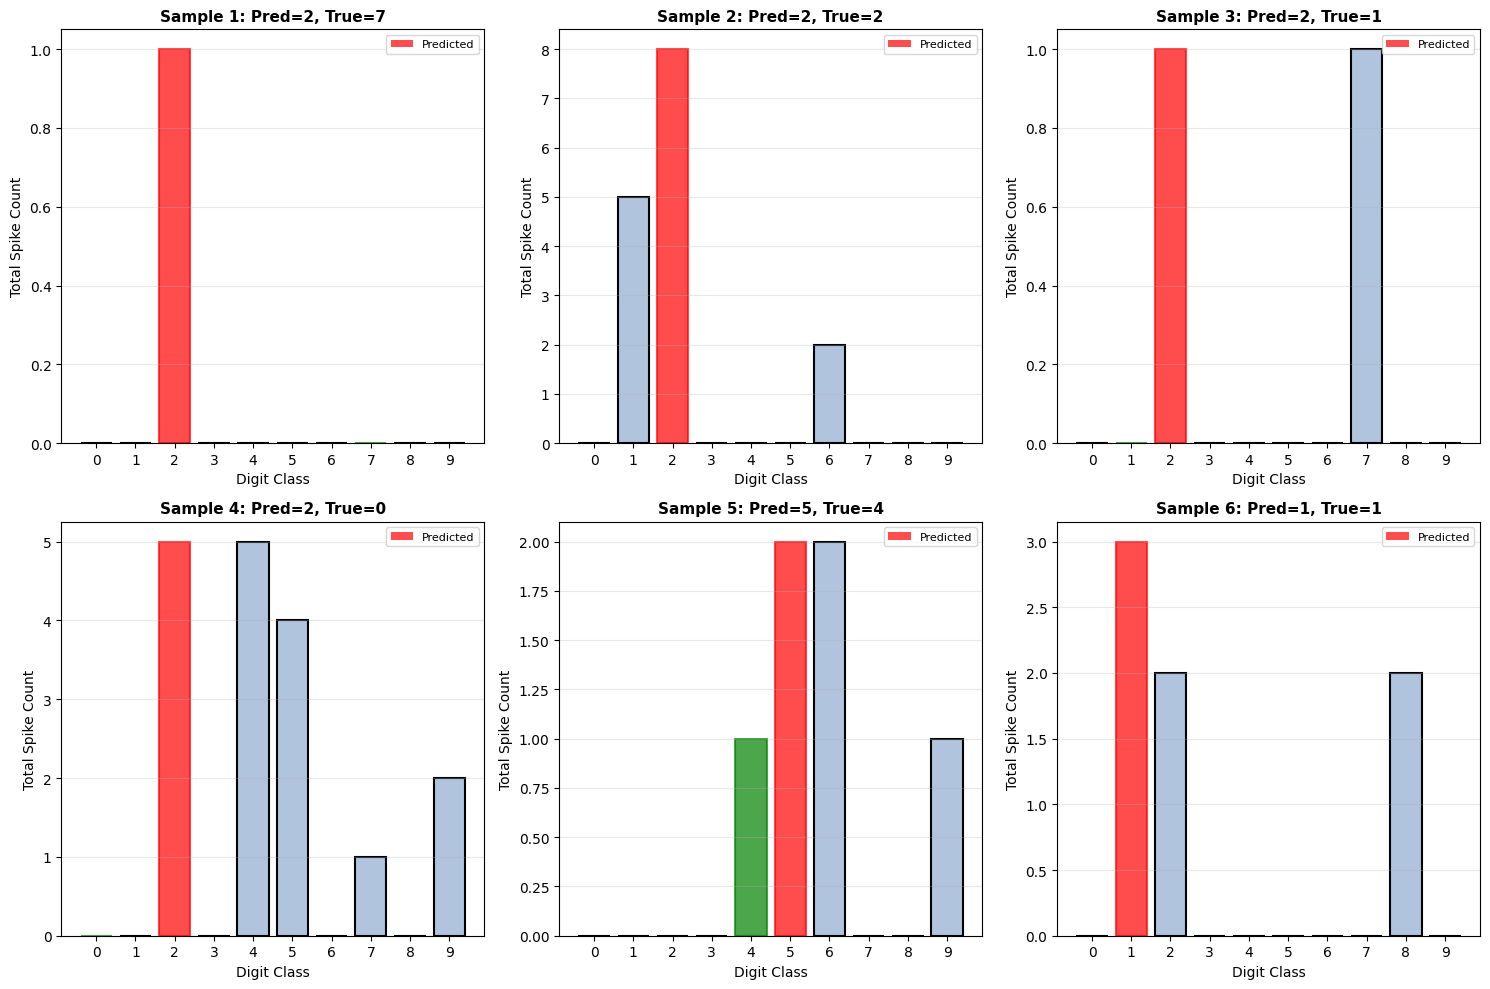

In [8]:
def classify_batch(net, data, labels, num_steps=50):
    """
    Classify a batch using spike count voting mechanism

    Classification rule: The output neuron with most spikes determines the predicted class
    """

    spk_rec, mem_rec = forward_pass_through_time(net, data, num_steps)

    spike_counts = spk_rec.sum(dim=0)

    predictions = spike_counts.argmax(dim=1)

    correct = (predictions == labels.cpu()).sum().item()
    accuracy = correct / len(labels) * 100

    return predictions, accuracy, spike_counts

test_batch, test_labels = next(iter(test_loader))

print(f"Testing on batch of {len(test_labels)} samples...")

predictions, accuracy, spike_counts = classify_batch(net, test_batch, test_labels, num_steps=50)

print(f"\nBatch size: {len(test_labels)}")
print(f"Accuracy (random weights): {accuracy:.2f}%")
print(f"Expected random accuracy: ~10% (1/10 classes)")
print(f"Correct predictions: {(predictions == test_labels.cpu()).sum().item()}/{len(test_labels)}")

print(f"\nFirst 10 predictions vs actual:")
print(f"Predicted: {predictions[:10].numpy()}")
print(f"Actual:    {test_labels[:10].numpy()}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx in range(6):

    bars = axes[idx].bar(range(10), spike_counts[idx].numpy(), color='lightsteelblue',
                         edgecolor='black', linewidth=1.5)

    bars[predictions[idx]].set_color('red')
    bars[predictions[idx]].set_alpha(0.7)

    if predictions[idx] != test_labels[idx]:
        bars[test_labels[idx]].set_color('green')
        bars[test_labels[idx]].set_alpha(0.7)

    axes[idx].set_xlabel('Digit Class', fontsize=10)
    axes[idx].set_ylabel('Total Spike Count', fontsize=10)
    axes[idx].set_title(f'Sample {idx+1}: Pred={predictions[idx].item()}, ' +
                       f'True={test_labels[idx].item()}', fontsize=11, fontweight='bold')
    axes[idx].set_xticks(range(10))
    axes[idx].grid(True, alpha=0.3, axis='y')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label='Predicted')]
    axes[idx].legend(handles=legend_elements, fontsize=8, loc='upper right')

plt.tight_layout()
plt.savefig('baseline_classification.png', dpi=150, bbox_inches='tight')
plt.show()



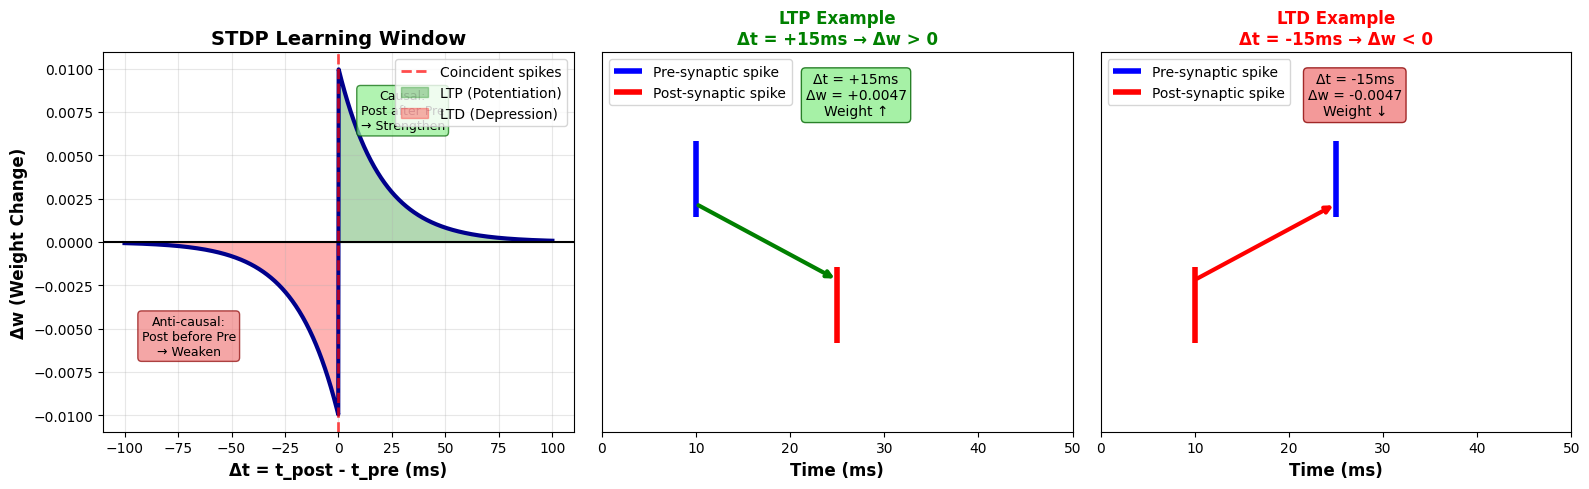


Potentiation (LTP):
  A⁺ (amplitude):      0.01
  τ⁺ (time constant):  20 ms

Depression (LTD):
  A⁻ (amplitude):      0.01
  τ⁻ (time constant):  20 ms


In [9]:

A_plus = 0.01    # LTP amplitude (potentiation)
A_minus = 0.01   # LTD amplitude (depression)
tau_plus = 20    # LTP time constant (ms)
tau_minus = 20   # LTD time constant (ms)

def stdp_weight_change(delta_t, A_plus=0.01, A_minus=0.01, tau_plus=20, tau_minus=20):
    """
    Calculate STDP weight change based on spike timing difference

    STDP Equations:
        If Δt > 0 (post fires AFTER pre):  Δw = A+ * exp(-Δt/τ+)   [LTP]
        If Δt < 0 (post fires BEFORE pre): Δw = -A- * exp(Δt/τ-)   [LTD]

    Args:
        delta_t: Time difference (t_post - t_pre) in milliseconds

    Returns:
        delta_w: Weight change
    """
    if delta_t > 0:  # LTP
        return A_plus * np.exp(-delta_t / tau_plus)
    elif delta_t < 0:  # LTD
        return -A_minus * np.exp(delta_t / tau_minus)
    else:
        return 0

delta_t_range = np.linspace(-100, 100, 1000)
stdp_curve = np.array([stdp_weight_change(dt, A_plus, A_minus, tau_plus, tau_minus)
                       for dt in delta_t_range])

fig = plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(delta_t_range, stdp_curve, linewidth=3, color='darkblue')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Coincident spikes')
ax1.fill_between(delta_t_range, stdp_curve, 0,
                  where=(stdp_curve > 0), alpha=0.3,
                  color='green', label='LTP (Potentiation)')
ax1.fill_between(delta_t_range, stdp_curve, 0,
                  where=(stdp_curve < 0), alpha=0.3,
                  color='red', label='LTD (Depression)')
ax1.set_xlabel('Δt = t_post - t_pre (ms)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Δw (Weight Change)', fontsize=12, fontweight='bold')
ax1.set_title('STDP Learning Window', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.text(30, 0.0065, 'Causal:\nPost after Pre\n→ Strengthen',
         fontsize=9, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen'))
ax1.text(-70, -0.0065, 'Anti-causal:\nPost before Pre\n→ Weaken',
         fontsize=9, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7, edgecolor='darkred'))

ax2 = plt.subplot(1, 3, 2)
pre_time = 10
post_time = 25
ax2.eventplot([pre_time], lineoffsets=1, colors='blue', linewidths=4,
              linelengths=0.3, label='Pre-synaptic spike')
ax2.eventplot([post_time], lineoffsets=0.5, colors='red', linewidths=4,
              linelengths=0.3, label='Post-synaptic spike')
ax2.annotate('', xy=(post_time, 0.6), xytext=(pre_time, 0.9),
            arrowprops=dict(arrowstyle='->', color='green', lw=3))
ax2.set_ylim(0, 1.5)
ax2.set_xlim(0, 50)
ax2.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
ax2.set_title('LTP Example\nΔt = +15ms → Δw > 0',
              fontsize=12, fontweight='bold', color='green')
ax2.legend(fontsize=10, loc='upper left')
ax2.set_yticks([])
delta_w_ltp = stdp_weight_change(15, A_plus, A_minus, tau_plus, tau_minus)
ax2.text(27, 1.25, f'Δt = +15ms\nΔw = +{delta_w_ltp:.4f}\nWeight ↑',
         fontsize=10, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, edgecolor='darkgreen'))

ax3 = plt.subplot(1, 3, 3)
pre_time = 25
post_time = 10
ax3.eventplot([pre_time], lineoffsets=1, colors='blue', linewidths=4,
              linelengths=0.3, label='Pre-synaptic spike')
ax3.eventplot([post_time], lineoffsets=0.5, colors='red', linewidths=4,
              linelengths=0.3, label='Post-synaptic spike')
ax3.annotate('', xy=(pre_time, 0.9), xytext=(post_time, 0.6),
            arrowprops=dict(arrowstyle='->', color='red', lw=3))
ax3.set_ylim(0, 1.5)
ax3.set_xlim(0, 50)
ax3.set_xlabel('Time (ms)', fontsize=12, fontweight='bold')
ax3.set_title('LTD Example\nΔt = -15ms → Δw < 0',
              fontsize=12, fontweight='bold', color='red')
ax3.legend(fontsize=10, loc='upper left')
ax3.set_yticks([])
delta_w_ltd = stdp_weight_change(-15, A_plus, A_minus, tau_plus, tau_minus)
ax3.text(27, 1.25, f'Δt = -15ms\nΔw = {delta_w_ltd:.4f}\nWeight ↓',
         fontsize=10, ha='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8, edgecolor='darkred'))

plt.tight_layout()
plt.savefig('stdp_learning_rule.png', dpi=150, bbox_inches='tight')
plt.show()


print(f"\nPotentiation (LTP):")
print(f"  A⁺ (amplitude):      {A_plus}")
print(f"  τ⁺ (time constant):  {tau_plus} ms")
print(f"\nDepression (LTD):")
print(f"  A⁻ (amplitude):      {A_minus}")
print(f"  τ⁻ (time constant):  {tau_minus} ms")



In [10]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
from snntorch import surrogate
import time
from tqdm import tqdm




num_steps_snn = 25          # timesteps per sample
beta_snn = 0.9              # LIF membrane decay
hidden_size_snn = 512       # hidden layer size
num_epochs_snn = 10         # number of epochs
lr_snn = 1e-3               # learning rate
alpha_reg = 1e-4            # spike-activity regularization strength

print("Supervised SNN Config:")
print(f"  Hidden size: {hidden_size_snn}")
print(f"  Timesteps:   {num_steps_snn}")
print(f"  Epochs:      {num_epochs_snn}")
print(f"  LR:          {lr_snn}")
print(f"  Device:      {device}")


spike_grad = surrogate.fast_sigmoid()  # surrogate gradient

class SupervisedSNN(nn.Module):
    """
    Fully-connected spiking network:
        784 -> 512 (LIF) -> 10 (LIF readout)
    Trained with BPTT using snnTorch surrogate gradients.
    """

    def __init__(self, beta=0.9, hidden_size=512, device='cuda'):
        super().__init__()
        self.device = torch.device(device)
        self.beta = beta

        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False)

        self.fc2 = nn.Linear(hidden_size, 10)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=False)

        self.to(self.device)

        print(f"\nSupervisedSNN initialized on {self.device}:")
        print(f"  Architecture: 784 -> {hidden_size} -> 10")
        print(f"  Beta: {beta}")

    def forward(self, x, num_steps):
        """
        x: (B, 1, 28, 28)
        Returns:
            spk2_rec: (T, B, 10)
            mem2_rec: (T, B, 10)
        """
        B = x.size(0)
        x_flat = x.view(B, -1)

        spk2_rec = []
        mem2_rec = []

        mem1 = torch.zeros(B, self.fc1.out_features, device=self.device)
        mem2 = torch.zeros(B, self.fc2.out_features, device=self.device)

        for t in range(num_steps):
            cur1 = self.fc1(x_flat)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        spk2_rec = torch.stack(spk2_rec)
        mem2_rec = torch.stack(mem2_rec)

        return spk2_rec, mem2_rec

snn_supervised = SupervisedSNN(beta=beta_snn,
                               hidden_size=hidden_size_snn,
                               device=device)
optimizer_snn = torch.optim.Adam(snn_supervised.parameters(), lr=lr_snn)
criterion = nn.CrossEntropyLoss()


train_acc_history = []
test_acc_history = []

def eval_supervised_snn(model, test_loader, num_steps, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            spk_rec, mem_rec = model(images, num_steps)
            spk_counts = spk_rec.sum(dim=0)  # (B, 10)
            _, predicted = spk_counts.max(dim=1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"\nTest Accuracy (Supervised SNN): {acc:.2f}%")
    return acc

def train_supervised_snn(model, train_loader, num_epochs, num_steps, device):
    model.train()
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)

        for batch_idx, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer_snn.zero_grad()

            spk_rec, mem_rec = model(images, num_steps)

            spk_counts = spk_rec.sum(dim=0)

            loss_ce = criterion(spk_counts, labels)

            reg_spike = spk_rec.mean()
            loss = loss_ce + alpha_reg * reg_spike

            loss.backward()
            optimizer_snn.step()

            epoch_loss += loss.item() * labels.size(0)

            # Accuracy
            _, predicted = spk_counts.max(dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc = 100.0 * correct / total
            pbar.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{acc:.1f}%'})

        epoch_loss /= total
        epoch_train_acc = 100.0 * correct / total
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Loss: {epoch_loss:.4f}")
        print(f"  Train Accuracy: {epoch_train_acc:.2f}%")

        train_acc_history.append(epoch_train_acc)

        epoch_test_acc = eval_supervised_snn(
            model=model,
            test_loader=test_loader,
            num_steps=num_steps,
            device=device
        )
        test_acc_history.append(epoch_test_acc)

        if device.type == 'cuda':
            torch.cuda.empty_cache()

    total_time = time.time() - start_time
    print(f"\nSupervised training complete in {total_time/60:.1f} minutes.")



print("\nsupervised SNN training with BPTT + surrogate gradients")
train_supervised_snn(
    model=snn_supervised,
    train_loader=train_loader,
    num_epochs=num_epochs_snn,
    num_steps=num_steps_snn,
    device=device
)

supervised_acc = eval_supervised_snn(
    model=snn_supervised,
    test_loader=test_loader,
    num_steps=num_steps_snn,
    device=device
)

print(f"\nSupervised SNN accuracy: {supervised_acc:.2f}%")


torch.save(snn_supervised.state_dict(), "supervised_snn_baseline.pt")


Supervised SNN Config:
  Hidden size: 512
  Timesteps:   25
  Epochs:      10
  LR:          0.001
  Device:      cpu

SupervisedSNN initialized on cpu:
  Architecture: 784 -> 512 -> 10
  Beta: 0.9

supervised SNN training with BPTT + surrogate gradients


Epoch 1/10: 100%|██████████████████████████| 468/468 [01:44<00:00,  4.49it/s, Loss=1.271, Acc=38.2%]


Epoch 1 Summary:
  Loss: 1.5223
  Train Accuracy: 38.20%



Test Accuracy (Supervised SNN): 46.94%


Epoch 2/10: 100%|██████████████████████████| 468/468 [01:43<00:00,  4.54it/s, Loss=0.515, Acc=67.2%]


Epoch 2 Summary:
  Loss: 0.8871
  Train Accuracy: 67.24%



Test Accuracy (Supervised SNN): 82.07%


Epoch 3/10: 100%|██████████████████████████| 468/468 [01:41<00:00,  4.60it/s, Loss=0.269, Acc=85.5%]


Epoch 3 Summary:
  Loss: 0.4677
  Train Accuracy: 85.51%



Test Accuracy (Supervised SNN): 93.41%


Epoch 4/10: 100%|██████████████████████████| 468/468 [01:41<00:00,  4.62it/s, Loss=0.212, Acc=93.2%]


Epoch 4 Summary:
  Loss: 0.2709
  Train Accuracy: 93.18%



Test Accuracy (Supervised SNN): 94.39%


Epoch 5/10: 100%|██████████████████████████| 468/468 [01:42<00:00,  4.58it/s, Loss=0.135, Acc=94.1%]


Epoch 5 Summary:
  Loss: 0.2360
  Train Accuracy: 94.09%



Test Accuracy (Supervised SNN): 94.48%


Epoch 6/10: 100%|██████████████████████████| 468/468 [01:48<00:00,  4.32it/s, Loss=0.249, Acc=94.7%]


Epoch 6 Summary:
  Loss: 0.2112
  Train Accuracy: 94.69%



Test Accuracy (Supervised SNN): 94.71%


Epoch 7/10: 100%|██████████████████████████| 468/468 [01:47<00:00,  4.35it/s, Loss=0.142, Acc=94.8%]


Epoch 7 Summary:
  Loss: 0.2033
  Train Accuracy: 94.80%



Test Accuracy (Supervised SNN): 95.30%


Epoch 8/10: 100%|██████████████████████████| 468/468 [01:46<00:00,  4.41it/s, Loss=0.146, Acc=95.0%]


Epoch 8 Summary:
  Loss: 0.1987
  Train Accuracy: 95.02%



Test Accuracy (Supervised SNN): 94.45%


Epoch 9/10: 100%|██████████████████████████| 468/468 [01:45<00:00,  4.43it/s, Loss=0.157, Acc=95.2%]


Epoch 9 Summary:
  Loss: 0.1951
  Train Accuracy: 95.19%



Test Accuracy (Supervised SNN): 94.54%


Epoch 10/10: 100%|█████████████████████████| 468/468 [01:45<00:00,  4.44it/s, Loss=0.099, Acc=95.3%]


Epoch 10 Summary:
  Loss: 0.1965
  Train Accuracy: 95.31%



Test Accuracy (Supervised SNN): 94.24%

Supervised training complete in 19.1 minutes.

Test Accuracy (Supervised SNN): 94.24%

Supervised SNN accuracy: 94.24%


In [11]:

import copy
from tqdm import tqdm

print("="*60)
print("SECTION 19: POST-TRAINING PLASTICITY ON SUPERVISED SNN")
print("="*60)

#baseline model and make a copy for plasticity
post_snn = SupervisedSNN(beta=beta_snn, hidden_size=hidden_size_snn, device=device)
state_dict = torch.load("supervised_snn_baseline.pt", map_location=device)
post_snn.load_state_dict(state_dict)

baseline_snn = SupervisedSNN(beta=beta_snn, hidden_size=hidden_size_snn, device=device)
baseline_snn.load_state_dict(copy.deepcopy(state_dict))
baseline_snn.eval()

print("\n✓ Loaded supervised baseline weights into post-training model.")

baseline_acc = eval_supervised_snn(baseline_snn, test_loader, num_steps_snn, device)
print(f"Baseline Test Accuracy (before post-training): {baseline_acc:.2f}%")

#  Local Post-Training Plasticity Rule
eta_fc1 = 1e-5   # learning rate for fc1
eta_fc2 = 1e-5   # learning rate for fc2
lambda_ltd = 0.5 # strength of anti-Hebbian term

num_post_epochs = 3
print("\nPost-Training Plasticity Config:")
print(f"  Post-training epochs: {num_post_epochs}")
print(f"  η_fc1: {eta_fc1}, η_fc2: {eta_fc2}, λ_LTD: {lambda_ltd}")

def post_training_step(model, images, num_steps):
    """
    One unsupervised plasticity step on a batch of images.
    Updates fc1 and fc2 weights using local Hebbian / anti-Hebbian terms.
    """
    model.train()
    images = images.to(device)
    B = images.size(0)

    with torch.no_grad():
        x_flat = images.view(B, -1)

        mem1 = torch.zeros(B, model.fc1.out_features, device=device)
        mem2 = torch.zeros(B, model.fc2.out_features, device=device)

        spk1_rec = []
        spk2_rec = []

        for t in range(num_steps):
            cur1 = model.fc1(x_flat)
            spk1, mem1 = model.lif1(cur1, mem1)

            cur2 = model.fc2(spk1)
            spk2, mem2 = model.lif2(cur2, mem2)

            spk1_rec.append(spk1)
            spk2_rec.append(spk2)

        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)

        pre1 = x_flat
        post1 = spk1_rec.mean(0)

        pre2 = post1
        post2 = spk2_rec.mean(0)

        w1 = model.fc1.weight.data
        w2 = model.fc2.weight.data

        # fc1 update
        hebb1 = torch.einsum('bi,bj->ij', pre1, post1) / B
        mean_post1 = post1.mean(dim=1, keepdim=True)
        anti1 = torch.einsum('bi,bk->ik', pre1, mean_post1) / B

        dw1 = eta_fc1 * (hebb1 - lambda_ltd * anti1)
        dw1 = dw1.T

        # fc2 updat
        hebb2 = torch.einsum('bi,bj->ij', pre2, post2) / B
        mean_post2 = post2.mean(dim=1, keepdim=True)
        anti2 = torch.einsum('bi,bk->ik', pre2, mean_post2) / B

        dw2 = eta_fc2 * (hebb2 - lambda_ltd * anti2)

        model.fc1.weight.data = torch.clamp(w1 + dw1, -1.0, 1.0)
        model.fc2.weight.data = torch.clamp(w2 + dw2.T, -1.0, 1.0)


def run_post_training(model, train_loader, test_loader, num_epochs, num_steps, device):
    print("\n" + "="*60)
    print("STARTING UNSUPERVISED POST-TRAINING PHASE")
    print("="*60)

    history_post = []

    acc0 = eval_supervised_snn(model, test_loader, num_steps, device)
    print(f"Accuracy before post-training: {acc0:.2f}%")
    history_post.append(("epoch_0", acc0))

    for epoch in range(1, num_epochs + 1):
        print(f"\n Post-Training Epoch {epoch}/{num_epochs}")

        for images, _ in tqdm(train_loader, desc=f"Post-Epoch {epoch}", ncols=100):
            post_training_step(model, images, num_steps)

        acc = eval_supervised_snn(model, test_loader, num_steps, device)
        print(f"Accuracy after post-training epoch {epoch}: {acc:.2f}%")
        history_post.append((f"epoch_{epoch}", acc))

    return history_post


post_history = run_post_training(
    model=post_snn,
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=num_post_epochs,
    num_steps=num_steps_snn,
    device=device
)

print("\nPost-training accuracy history:")
for ep, acc in post_history:
    print(f"  {ep}: {acc:.2f}%")

torch.save(post_snn.state_dict(), "supervised_snn_post_trained.pt")


SECTION 19: POST-TRAINING PLASTICITY ON SUPERVISED SNN

SupervisedSNN initialized on cpu:
  Architecture: 784 -> 512 -> 10
  Beta: 0.9

SupervisedSNN initialized on cpu:
  Architecture: 784 -> 512 -> 10
  Beta: 0.9

✓ Loaded supervised baseline weights into post-training model.

Test Accuracy (Supervised SNN): 94.24%
Baseline Test Accuracy (before post-training): 94.24%

Post-Training Plasticity Config:
  Post-training epochs: 3
  η_fc1: 1e-05, η_fc2: 1e-05, λ_LTD: 0.5

STARTING UNSUPERVISED POST-TRAINING PHASE

Test Accuracy (Supervised SNN): 94.24%
Accuracy before post-training: 94.24%

 Post-Training Epoch 1/3


Post-Epoch 1: 100%|███████████████████████████████████████████████| 468/468 [01:03<00:00,  7.39it/s]



Test Accuracy (Supervised SNN): 93.50%
Accuracy after post-training epoch 1: 93.50%

 Post-Training Epoch 2/3


Post-Epoch 2: 100%|███████████████████████████████████████████████| 468/468 [01:02<00:00,  7.43it/s]



Test Accuracy (Supervised SNN): 92.43%
Accuracy after post-training epoch 2: 92.43%

 Post-Training Epoch 3/3


Post-Epoch 3: 100%|███████████████████████████████████████████████| 468/468 [01:00<00:00,  7.75it/s]



Test Accuracy (Supervised SNN): 90.94%
Accuracy after post-training epoch 3: 90.94%

Post-training accuracy history:
  epoch_0: 94.24%
  epoch_1: 93.50%
  epoch_2: 92.43%
  epoch_3: 90.94%


Generating ALL report figures with final results...


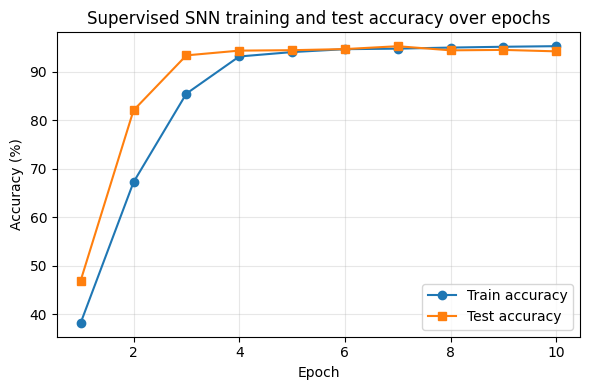

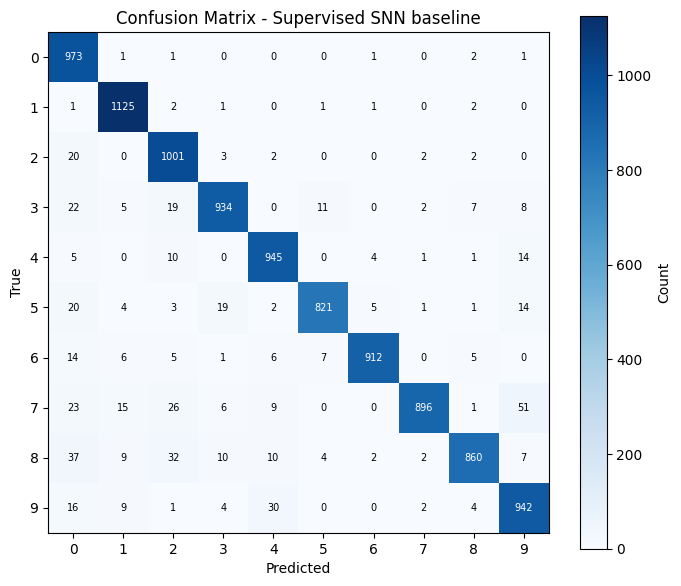

Baseline metrics:

Per-class metrics (digits 0–9):
Digit | Precision | Recall | F1
--------------------------------
  0   |   0.860  |  0.994 |  0.922
  1   |   0.958  |  0.993 |  0.975
  2   |   0.910  |  0.972 |  0.940
  3   |   0.955  |  0.927 |  0.941
  4   |   0.941  |  0.964 |  0.953
  5   |   0.973  |  0.922 |  0.947
  6   |   0.986  |  0.954 |  0.970
  7   |   0.989  |  0.872 |  0.927
  8   |   0.972  |  0.884 |  0.926
  9   |   0.908  |  0.935 |  0.921
--------------------------------
Macro-avg Precision: 0.945
Macro-avg Recall:    0.942
Macro-avg F1:        0.942


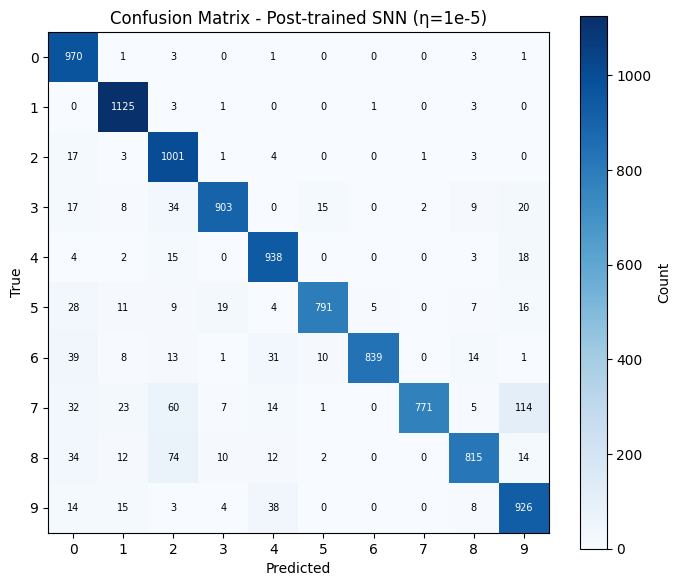


Post-trained metrics:

Per-class metrics (digits 0–9):
Digit | Precision | Recall | F1
--------------------------------
  0   |   0.840  |  0.991 |  0.909
  1   |   0.931  |  0.993 |  0.961
  2   |   0.824  |  0.972 |  0.892
  3   |   0.955  |  0.896 |  0.924
  4   |   0.900  |  0.957 |  0.928
  5   |   0.966  |  0.889 |  0.926
  6   |   0.993  |  0.878 |  0.932
  7   |   0.996  |  0.751 |  0.856
  8   |   0.937  |  0.838 |  0.884
  9   |   0.834  |  0.919 |  0.874
--------------------------------
Macro-avg Precision: 0.918
Macro-avg Recall:    0.908
Macro-avg F1:        0.909


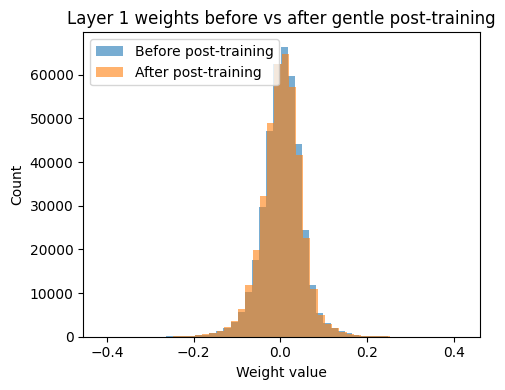

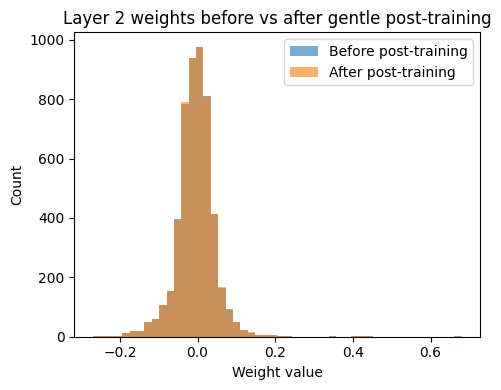

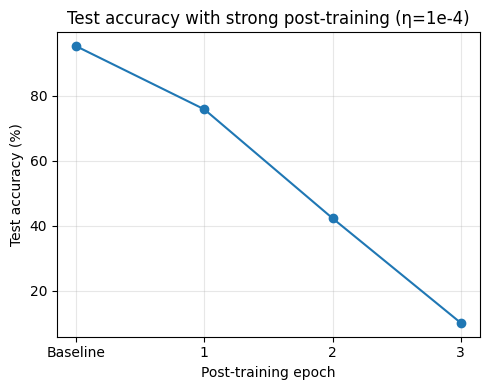

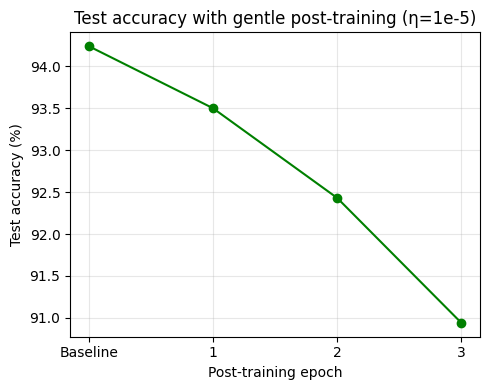

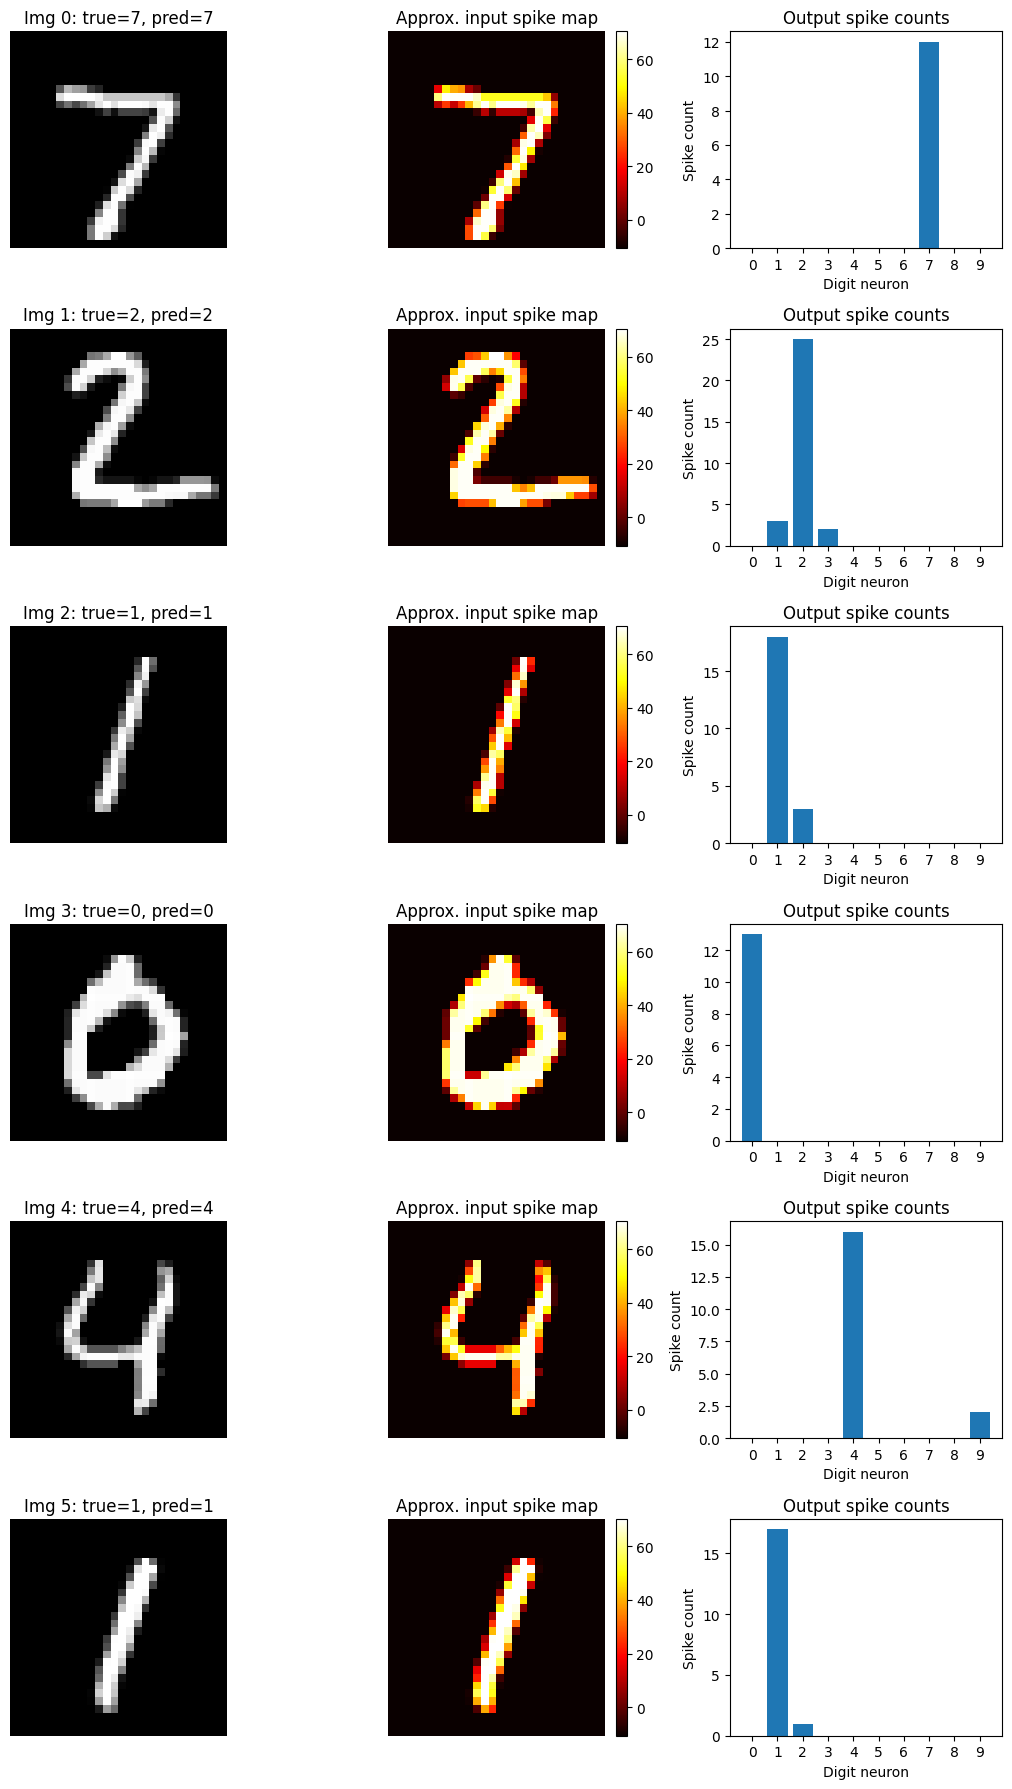

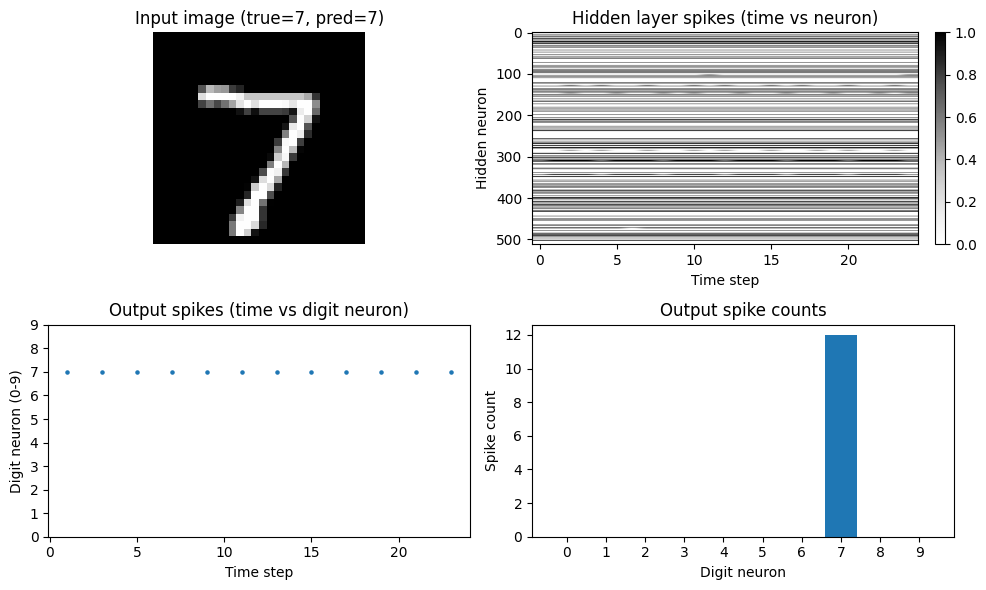

In [14]:

#  results and graphs

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

train_acc_history = [
    38.20, 67.24, 85.51, 93.18, 94.09,
    94.69, 94.80, 95.02, 95.19, 95.31
]

test_acc_history = [
    46.94, 82.07, 93.41, 94.39, 94.48,
    94.71, 95.30, 94.45, 94.54, 94.24
]

gentle_post_acc = [94.24, 93.50, 92.43, 90.94]

strong_post_acc = [95.15, 75.75, 42.30, 10.18]


def plot_train_test_accuracy(train_acc_history, test_acc_history,
                             filename="snn_train_test_accuracy.png"):
    num_epochs = len(train_acc_history)
    epochs = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_acc_history, marker='o', label="Train accuracy")
    plt.plot(epochs, test_acc_history, marker='s', label="Test accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Supervised SNN training and test accuracy over epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def compute_confusion_and_metrics(model, test_loader, num_steps, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            spk_rec, _ = model(images, num_steps)
            spk_counts = spk_rec.sum(dim=0)
            preds = spk_counts.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(10)))
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, labels=list(range(10)), zero_division=0
    )

    return cm, precision, recall, f1

def plot_confusion_matrix_cm(cm, model_name, filename):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix - " + model_name)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar(label="Count")
    ticks = np.arange(10)
    plt.xticks(ticks)
    plt.yticks(ticks)
    for i in range(10):
        for j in range(10):
            val = cm[i, j]
            color = "white" if val > cm.max() / 2 else "black"
            plt.text(j, i, str(val), ha='center', va='center',
                     color=color, fontsize=7)

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()

def print_per_class_metrics(precision, recall, f1):
    print("\nPer-class metrics (digits 0–9):")
    print("Digit | Precision | Recall | F1")
    print("--------------------------------")
    for d in range(10):
        print(f"  {d}   |  {precision[d]:6.3f}  | {recall[d]:6.3f} | {f1[d]:6.3f}")
    print("--------------------------------")
    print(f"Macro-avg Precision: {precision.mean():.3f}")
    print(f"Macro-avg Recall:    {recall.mean():.3f}")
    print(f"Macro-avg F1:        {f1.mean():.3f}")


def generate_confusion_matrices(baseline_snn, post_snn,
                                test_loader, num_steps_snn, device):
    base_model = baseline_snn.to(device)
    base_model.eval()
    cm_base, p_b, r_b, f_b = compute_confusion_and_metrics(
        base_model, test_loader, num_steps_snn, device
    )
    plot_confusion_matrix_cm(cm_base,
                             model_name="Supervised SNN baseline",
                             filename="cm_supervised_snn.png")
    print("Baseline metrics:")
    print_per_class_metrics(p_b, r_b, f_b)

    post_model = post_snn.to(device)
    post_model.eval()
    cm_post, p_p, r_p, f_p = compute_confusion_and_metrics(
        post_model, test_loader, num_steps_snn, device
    )
    plot_confusion_matrix_cm(cm_post,
                             model_name="Post-trained SNN (η=1e-5)",
                             filename="cm_post_trained_snn.png")
    print("\nPost-trained metrics:")
    print_per_class_metrics(p_p, r_p, f_p)


def generate_weight_histograms(baseline_snn, post_snn):
    w1_before = baseline_snn.fc1.weight.detach().cpu().numpy().ravel()
    w1_after  = post_snn.fc1.weight.detach().cpu().numpy().ravel()

    w2_before = baseline_snn.fc2.weight.detach().cpu().numpy().ravel()
    w2_after  = post_snn.fc2.weight.detach().cpu().numpy().ravel()


    plt.figure(figsize=(5,4))
    plt.hist(w1_before, bins=50, alpha=0.6, label="Before post-training")
    plt.hist(w1_after,  bins=50, alpha=0.6, label="After post-training")
    plt.xlabel("Weight value")
    plt.ylabel("Count")
    plt.title("Layer 1 weights before vs after gentle post-training")
    plt.legend()
    plt.tight_layout()
    plt.savefig("weight_hist_layer1.png", dpi=150, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(5,4))
    plt.hist(w2_before, bins=50, alpha=0.6, label="Before post-training")
    plt.hist(w2_after,  bins=50, alpha=0.6, label="After post-training")
    plt.xlabel("Weight value")
    plt.ylabel("Count")
    plt.title("Layer 2 weights before vs after gentle post-training")
    plt.legend()
    plt.tight_layout()
    plt.savefig("weight_hist_layer2.png", dpi=150, bbox_inches='tight')
    plt.show()

def plot_post_training_accuracy_curves(
    strong_acc=strong_post_acc,
    gentle_acc=gentle_post_acc
):

    epochs_strong = np.arange(0, len(strong_acc))
    plt.figure(figsize=(5,4))
    plt.plot(epochs_strong, strong_acc, marker='o')
    plt.xticks(epochs_strong, ["Baseline","1","2","3"])
    plt.xlabel("Post-training epoch")
    plt.ylabel("Test accuracy (%)")
    plt.title("Test accuracy with strong post-training (η=1e-4)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("post_training_strong_lr.png", dpi=150, bbox_inches='tight')
    plt.show()


    epochs_gentle = np.arange(0, len(gentle_acc))
    plt.figure(figsize=(5,4))
    plt.plot(epochs_gentle, gentle_acc, marker='o', color='green')
    plt.xticks(epochs_gentle, ["Baseline","1","2","3"])
    plt.xlabel("Post-training epoch")
    plt.ylabel("Test accuracy (%)")
    plt.title("Test accuracy with gentle post-training (η=1e-5)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("post_training_gentle_lr.png", dpi=150, bbox_inches='tight')
    plt.show()


def get_example_batch(test_loader, num_batches=1):
    for i, (images, labels) in enumerate(test_loader):
        if i >= num_batches:
            break
        return images, labels
    return None, None


def visualize_spike_heatmaps(model, test_loader, num_steps, device,
                             num_examples=6,
                             filename="snn_spike_heatmaps_post_trained.png"):
    model.eval()
    images, labels = get_example_batch(test_loader, num_batches=1)
    images = images.to(device)
    labels = labels.to(device)

    B = images.size(0)
    num_examples = min(num_examples, B)

    with torch.no_grad():
        spk_rec, mem_rec = model(images, num_steps)
    spk_counts = spk_rec.sum(dim=0)
    preds = spk_counts.argmax(dim=1)

    input_spike_maps = (images * num_steps).cpu().numpy()

    cols = 3
    rows = num_examples
    plt.figure(figsize=(cols * 3.5, rows * 3.0))

    for i in range(num_examples):
        img = images[i, 0].cpu().numpy()
        true_label = labels[i].item()
        pred_label = preds[i].item()
        out_counts = spk_counts[i].cpu().numpy()
        in_spikes = input_spike_maps[i, 0]


        ax1 = plt.subplot(rows, cols, i*cols + 1)
        ax1.imshow(img, cmap='gray')
        ax1.set_title(f"Img {i}: true={true_label}, pred={pred_label}")
        ax1.axis('off')


        ax2 = plt.subplot(rows, cols, i*cols + 2)
        hm = ax2.imshow(in_spikes, cmap='hot')
        ax2.set_title("Approx. input spike map")
        ax2.axis('off')
        plt.colorbar(hm, ax=ax2, fraction=0.046, pad=0.04)


        ax3 = plt.subplot(rows, cols, i*cols + 3)
        ax3.bar(np.arange(10), out_counts)
        ax3.set_xticks(np.arange(10))
        ax3.set_xlabel("Digit neuron")
        ax3.set_ylabel("Spike count")
        ax3.set_title("Output spike counts")

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()


def visualize_hidden_activity_for_image(model, image, label, num_steps, device,
                                        filename="snn_hidden_activity_example_post_trained.png"):
    model.eval()
    image = image.unsqueeze(0).to(device)
    label = label.item() if torch.is_tensor(label) else label

    with torch.no_grad():
        B = image.size(0)
        x_flat = image.view(B, -1)

        mem1 = torch.zeros(B, model.fc1.out_features, device=device)
        mem2 = torch.zeros(B, model.fc2.out_features, device=device)

        spk1_rec = []
        spk2_rec = []

        for t in range(num_steps):
            cur1 = model.fc1(x_flat)
            spk1, mem1 = model.lif1(cur1, mem1)
            cur2 = model.fc2(spk1)
            spk2, mem2 = model.lif2(cur2, mem2)
            spk1_rec.append(spk1)
            spk2_rec.append(spk2)

        spk1_rec = torch.stack(spk1_rec)
        spk2_rec = torch.stack(spk2_rec)

    spk1_np = spk1_rec.squeeze(1).cpu().numpy()
    spk2_np = spk2_rec.squeeze(1).cpu().numpy()
    spk2_counts = spk2_np.sum(axis=0)
    pred_label = int(np.argmax(spk2_counts))

    plt.figure(figsize=(10,6))


    ax1 = plt.subplot(2,2,1)
    ax1.imshow(image[0,0].cpu().numpy(), cmap='gray')
    ax1.set_title(f"Input image (true={label}, pred={pred_label})")
    ax1.axis('off')


    ax2 = plt.subplot(2,2,2)
    im2 = ax2.imshow(spk1_np.T, aspect='auto', cmap='Greys')
    ax2.set_title("Hidden layer spikes (time vs neuron)")
    ax2.set_xlabel("Time step")
    ax2.set_ylabel("Hidden neuron")
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)


    ax3 = plt.subplot(2,2,3)
    t_idx, neuron_idx = np.nonzero(spk2_np)
    ax3.scatter(t_idx, neuron_idx, s=5)
    ax3.set_title("Output spikes (time vs digit neuron)")
    ax3.set_xlabel("Time step")
    ax3.set_ylabel("Digit neuron (0-9)")
    ax3.set_yticks(np.arange(10))

    ax4 = plt.subplot(2,2,4)
    ax4.bar(np.arange(10), spk2_counts)
    ax4.set_xticks(np.arange(10))
    ax4.set_xlabel("Digit neuron")
    ax4.set_ylabel("Spike count")
    ax4.set_title("Output spike counts")

    plt.tight_layout()
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()




print("Generating ALL report figures with final results...")


baseline_snn = snn_supervised

plot_train_test_accuracy(train_acc_history, test_acc_history)

generate_confusion_matrices(baseline_snn, post_snn,
                            test_loader, num_steps_snn, device)

generate_weight_histograms(baseline_snn, post_snn)

plot_post_training_accuracy_curves()

visualize_spike_heatmaps(
    model=post_snn.to(device),
    test_loader=test_loader,
    num_steps=num_steps_snn,
    device=device,
    num_examples=6,
    filename="snn_spike_heatmaps_post_trained.png"
)

example_images, example_labels = next(iter(test_loader))
visualize_hidden_activity_for_image(
    model=post_snn.to(device),
    image=example_images[0],
    label=example_labels[0],
    num_steps=num_steps_snn,
    device=device,
    filename="snn_hidden_activity_example_post_trained.png"
)


